# Question 1 - Scrapping Wikipedia Page

In [1]:
#Importing necessary libraries
import pandas as pd
from bs4 import BeautifulSoup
import requests


In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# Getting html from wiki page and create soup object
source = requests.get(url)
beautiful_soup = BeautifulSoup(source.text, 'lxml')

#using soup object, iterate the .wikitable to get the data from the HTML page and store it into a list
data = []
columns = []
table = beautiful_soup.find(class_='wikitable')
for index, tr in enumerate(table.find_all('tr')):
    input_section = []
    for td in tr.find_all(['th','td']):
        input_section.append(td.text.rstrip())
    
    #First row of data is the header
    if (index == 0):
        columns = input_section
    else:
        data.append(input_section)

In [3]:
#Converting lists into Pandas DataFrame, ignoring Not assigned Borough
dataset = pd.DataFrame(data = data,columns = columns)
dataset = dataset[dataset['Borough'] != 'Not assigned']
dataset = dataset.reset_index(drop=True)
dataset.head(12)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [4]:
dataset.shape

(103, 3)

# Question 2 - Retrieving latitude and longitude from postal code

In [5]:
dataset['Latitude'] = 0
dataset['Longitude'] = 0

# Using the csv file with coordinates as the geocoder library didn't work for me.
geospatial_coordinates = pd.read_csv('Geospatial_Coordinates.csv')
print(geospatial_coordinates.shape)
geospatial_coordinates.head()

(103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
#Retrieving Latitude and Longitude from geospatial_coordinates dataset.
index = 0
for postal_code in dataset['Postal Code']:    
    lat_lon = geospatial_coordinates[geospatial_coordinates['Postal Code'] == postal_code]
    dataset.loc[index, 'Latitude'] = lat_lon['Latitude'].iloc[0]
    dataset.loc[index, 'Longitude'] = lat_lon['Longitude'].iloc[0]
    index += 1

In [7]:
dataset.head(12)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


# Question 3 - Exploring and clustering the neighborhoods in Toronto

Let's get the geographical coordinates of Toronto.

In [8]:
# Using hardcoded latitude and longitude as the Geocoder library timed out on the request.
latitude = 43.6532
longitude = -79.3832
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6532, -79.3832.


Creating a map of Toronto with neighborhoods superimposed on top.

In [9]:
# create map of Toronto using latitude and longitude values
import folium
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dataset['Latitude'], dataset['Longitude'], dataset['Borough'], dataset['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Defining Foursquare Credentials and Version

In [10]:
CLIENT_ID = 'K5GZUIMJ0ZZLWFHJSTN25NDPT13M51F40F5TLVIBOENLUGO1' # your Foursquare ID
CLIENT_SECRET = 'YZGOHLD0QMMTOVL5QETQVN4I2WHNIURFRVRGYOXYH4304X55' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K5GZUIMJ0ZZLWFHJSTN25NDPT13M51F40F5TLVIBOENLUGO1
CLIENT_SECRET:YZGOHLD0QMMTOVL5QETQVN4I2WHNIURFRVRGYOXYH4304X55


Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
dataset_toronto = dataset[dataset['Borough'].str.contains("Toronto")]
dataset_toronto = dataset_toronto.reset_index(drop=True)
print(dataset_toronto.shape)
dataset_toronto.head()

(39, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [13]:
toronto_venues = getNearbyVenues(names=dataset_toronto['Neighborhood'],
                                   latitudes=dataset_toronto['Latitude'],
                                   longitudes=dataset_toronto['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


Let's check the size of the resulting dataframe

In [14]:
print(toronto_venues.shape)
toronto_venues.head()

(1616, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


Let's check how many venues were returned for each neighborhood

In [15]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",14,14,14,14,14,14
Central Bay Street,62,62,62,62,62,62
Christie,17,17,17,17,17,17
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


Let's find out how many unique categories can be curated from all the returned venues

In [16]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


### Analyzing Each Neighborhood

In [17]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(1616, 236)


,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [18]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.071429,0.071429,0.142857,0.142857,0.142857,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.016129,0.000000,0.000000,0.016129,0.000000,0.000000
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.025974,0.012987,0.000000,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,...,0.012987,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Let's print each neighborhood along with the top 5 most common venues

In [19]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
          venue  freq
0   Coffee Shop  0.07
1  Cocktail Bar  0.05
2      Beer Bar  0.03
3          Café  0.03
4           Pub  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1     Coffee Shop  0.09
2  Breakfast Spot  0.09
3       Nightclub  0.09
4    Intersection  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                venue  freq
0  Light Rail Station  0.12
1         Yoga Studio  0.06
2       Auto Workshop  0.06
3          Comic Shop  0.06
4                Park  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0    Airport Lounge  0.14
1   Airport Service  0.14
2  Airport Terminal  0.14
3             Plane  0.07
4   Harbor / Marina  0.07


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.18
1      Sandwich Place  0.06


First, let's write a function to sort the venues in descending order.

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [21]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Cheese Shop,Beer Bar,Bakery,Restaurant,Pub,Café,Lounge
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Gym,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Auto Workshop,Smoke Shop,Brewery,Spa,Farmers Market,Fast Food Restaurant,Burrito Place,Butcher,Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Boat or Ferry,Boutique,Airport,Airport Food Court,Harbor / Marina,Bar,Sculpture Garden
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Japanese Restaurant,Salad Place,Bubble Tea Shop,Yoga Studio,Hotel


### Cluster Neighborhood

Run *k*-means to cluster the neighborhood into 5 clusters.

In [22]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = dataset_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Mexican Restaurant,Shoe Store,Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Gym,Diner,Restaurant,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Hobby Shop,Wings Joint
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Middle Eastern Restaurant,Café,Cosmetics Shop,Italian Restaurant,Japanese Restaurant,Restaurant,Bubble Tea Shop,Ramen Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,Gastropub,American Restaurant,Restaurant,Gym,Beer Bar,Hotel,Italian Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Park,Coffee Shop,Health Food Store,Trail,Pub,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Diner


Finally, let's visualize the resulting clusters

In [25]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

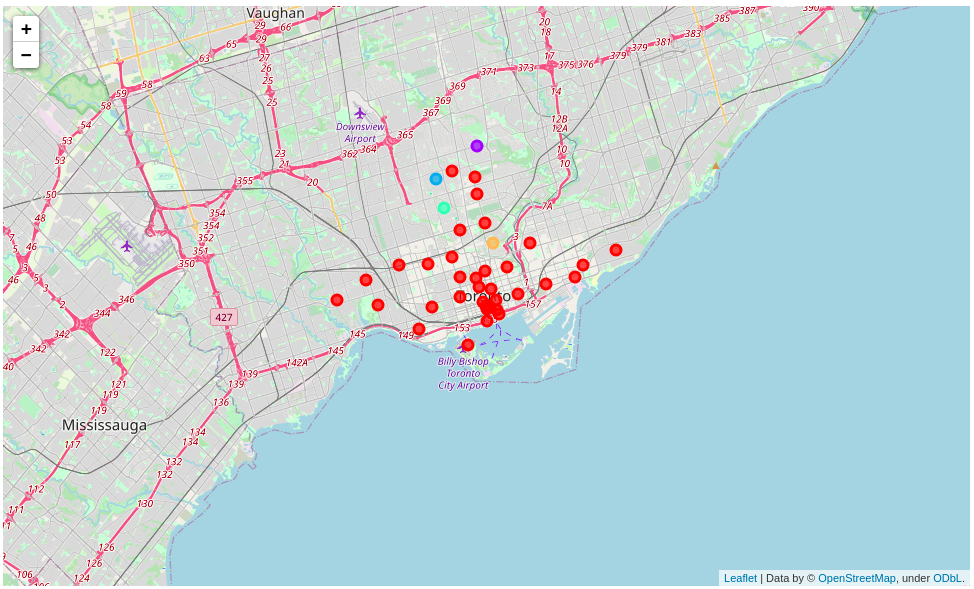

In [26]:
from IPython.display import Image
Image("map_toronto.png")